# Lab 1 code

## Imports

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tabulate import tabulate
import os

## Parameters

In [35]:
a0 = 0.0
a1 = 0.22
a2 = -0.18
a3 = 0.08
b1 = 0.5
b2 = 0.25
b3 = 0.25

## Data

### Generate

In [36]:
def generate_data(n_points=100, noise_std=0.1, seed=42):
    np.random.seed(seed)
    v = np.random.normal(0, noise_std, n_points)          # шум v(k)
    eps = np.random.normal(0, noise_std, n_points)        # додатковий шум ε
    y = np.zeros(n_points)

    # початкові значення
    y[0:3] = np.random.normal(0, 0.1, 3)

    for k in range(3, n_points):
        y[k] = (a0 +
                a1*y[k-1] + a2*y[k-2] + a3*y[k-3] +
                v[k] + b1*v[k-1] + b2*v[k-2] + b3*v[k-3] +
                eps[k])
    return y, v

### Load

In [37]:
def load_data():
    data_dir = "data"
    y_file = os.path.join(data_dir, 'y.txt')
    v_file = os.path.join(data_dir, 'v.txt')
    
    if not os.path.exists(y_file) or not os.path.exists(v_file):
        raise FileNotFoundError(f"Required files not found: {y_file}, {v_file}")
    
    y = np.loadtxt(y_file)
    v = np.loadtxt(v_file)
    
    return y, v

## Metrics

In [38]:
def calc_metrics(y_true, y_pred, k_params):
    n = len(y_true)
    S = np.sum((y_true - y_pred)**2)
    R2 = r2_score(y_true, y_pred)
    AIC = n*np.log(S/n) + 2*k_params
    return S, R2, AIC

## Model evaluation

In [39]:
def arcs_model(y, v, p, q, method="ols"):
    n = len(y)
    max_lag = max(p, q)
    X, Y = [], []
    for k in range(max_lag, n):
        row = [1.0]
        for i in range(1, p+1):
            row.append(y[k-i])
        row.append(v[k])
        for j in range(1, q+1):
            row.append(v[k-j])
        X.append(row)
        Y.append(y[k])
    X, Y = np.array(X), np.array(Y)

    if method == "ols":
        model = LinearRegression(fit_intercept=False).fit(X, Y)
        y_pred = model.predict(X)
    else:  # Рекурсивний МНК
        lam, delta = 1.0, 1000
        theta = np.zeros((X.shape[1], 1))
        P = delta * np.eye(X.shape[1])
        y_pred = np.zeros(len(Y))
        for k in range(len(Y)):
            phi_k = X[k].reshape(-1, 1)
            denom = lam + (phi_k.T @ P @ phi_k)
            K = P @ phi_k / denom
            e = Y[k] - (phi_k.T @ theta).item()
            theta = theta + K * e
            P = (P - K @ phi_k.T @ P) / lam
            y_pred[k] = (phi_k.T @ theta).item()
    return calc_metrics(Y, y_pred, X.shape[1])

## Models comparison

In [40]:
def build_wide_table(y, v):
    rows = []
    for p in range(1, 4):
        for q in range(1, 4):
            # OLS model
            S_ols, R2_ols, AIC_ols = arcs_model(y, v, p, q, "ols")
            
            # Ridge regression model
            S_r, R2_r, AIC_r = arcs_model(y, v, p, q, "ridge")
            
            rows.append({
                "Model": f"ARCS({p},{q})",
                "OLS S": S_ols,
                "OLS R²": R2_ols,
                "OLS AIC": AIC_ols,
                "Ridge S": S_r,
                "Ridge R²": R2_r,
                "Ridge AIC": AIC_r
            })
    
    return pd.DataFrame(rows).set_index("Model")

## Recursive estimation of coefficients

In [41]:
def recursive_estimation(y, v, p=3, q=3, method="ols"):
    n = len(y)
    max_lag = max(p, q)
    coeffs = []
    theta = None
    P = None
    lam = 1.0

    for t in range(max_lag + p + q + 2, n):
        X_hist, Y_hist = [], []
        for tau in range(max_lag, t+1):
            row = [1.0]
            for i in range(1, p+1):
                row.append(y[tau-i])
            row.append(v[tau])
            for j in range(1, q+1):
                row.append(v[tau-j])
            X_hist.append(row)
            Y_hist.append(y[tau])
        X_hist, Y_hist = np.array(X_hist), np.array(Y_hist)

        if method == "ols":
            model = LinearRegression(fit_intercept=False).fit(X_hist, Y_hist)
            coeffs.append(model.coef_.copy())
        else:
            if theta is None:
                theta = np.zeros((X_hist.shape[1], 1))
                P = 1000 * np.eye(X_hist.shape[1])
            for k in range(len(Y_hist)):
                phi_k = X_hist[k].reshape(-1, 1)
                denom = lam + (phi_k.T @ P @ phi_k)
                K = P @ phi_k / denom
                e = Y_hist[k] - (phi_k.T @ theta).item()
                theta = theta + K * e
                P = (P - K @ phi_k.T @ P) / lam
            coeffs.append(theta.ravel().copy())
    return np.array(coeffs)


## Plots

### Evolution plots

In [42]:
def plot_coefficients_evolution(real_coeffs, est_mnk, est_rmnk):
    names = list(real_coeffs.keys())
    fig, axes = plt.subplots(len(names), 1, figsize=(12, 3*len(names)))
    if len(names) == 1: axes = [axes]
    k = np.arange(est_mnk.shape[0])
    coef_indices = list(range(len(names)))
    
    for i, (ax, name) in enumerate(zip(axes, names)):
        real_val = real_coeffs[name]
        coef_idx = coef_indices[i]
        
        ax.axhline(y=real_val, color='k', linestyle='-', linewidth=2, label="Real")
        ax.plot(k, est_mnk[:, coef_idx], 'r-', label="OLS")
        ax.plot(k, est_rmnk[:, coef_idx], 'g-', label="Ridge")
        ax.set_title(f"Coefficient {name}")
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Accuracy plots

In [43]:
def build_table(y, v, max_p=3, max_q=3):
    results_mnk, results_rmnk, labels = [], [], []
    for p in range(1, max_p+1):
        for q in range(1, max_q+1):
            S_mnk, R2_mnk, AIC_mnk = arcs_model(y, v, p, q, "ols")
            S_rmnk, R2_rmnk, AIC_rmnk = arcs_model(y, v, p, q, "ridge")
            results_mnk.append((S_mnk, R2_mnk, AIC_mnk))
            results_rmnk.append((S_rmnk, R2_rmnk, AIC_rmnk))
            labels.append(f"ARCS({p},{q})")
    return labels, np.array(results_mnk), np.array(results_rmnk)

def plot_model_quality(labels, results_mnk, results_rmnk):
    metrics = ["S (∑e²)", "R²", "AIC"]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, ax in enumerate(axes):
        ax.plot(labels, results_mnk[:, i], "r--o", label="OLS")
        ax.plot(labels, results_rmnk[:, i], "g-s", label="Ridge")
        ax.set_title(metrics[i])
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45)
        ax.grid(True, alpha=0.3)
        ax.legend()
    plt.tight_layout()
    plt.show()

## Main

Data loaded for your model.

Results of 9 models (1 ≤ p ≤ 3, 1 ≤ q ≤ 3):
+-----------+----------+----------+-------------+----------+----------+-------------+
|   Model   |  OLS S   |  OLS R²  |   OLS AIC   | Ridge S  | Ridge R² |  Ridge AIC  |
+-----------+----------+----------+-------------+----------+----------+-------------+
| ARCS(1,1) | 0.101870 | 0.434556 | -649.447369 | 0.057695 | 0.679752 | -704.024953 |
| ARCS(1,2) | 0.050763 | 0.211149 | -705.773724 | 0.036016 | 0.440322 | -738.379285 |
| ARCS(1,3) | 0.030523 | 0.525665 | -743.060762 | 0.018396 | 0.714123 | -790.657768 |
| ARCS(2,1) | 0.036671 | 0.430140 | -736.666419 | 0.025244 | 0.607713 | -772.139237 |
| ARCS(2,2) | 0.036662 | 0.430273 | -734.688589 | 0.024089 | 0.625667 | -774.589785 |
| ARCS(2,3) | 0.013943 | 0.783318 | -814.707942 | 0.008737 | 0.864228 | -858.648971 |
| ARCS(3,1) | 0.008585 | 0.866593 | -862.300427 | 0.007468 | 0.883949 | -875.402224 |
| ARCS(3,2) | 0.008518 | 0.867626 | -861.031407 | 0.007179 | 0.8884

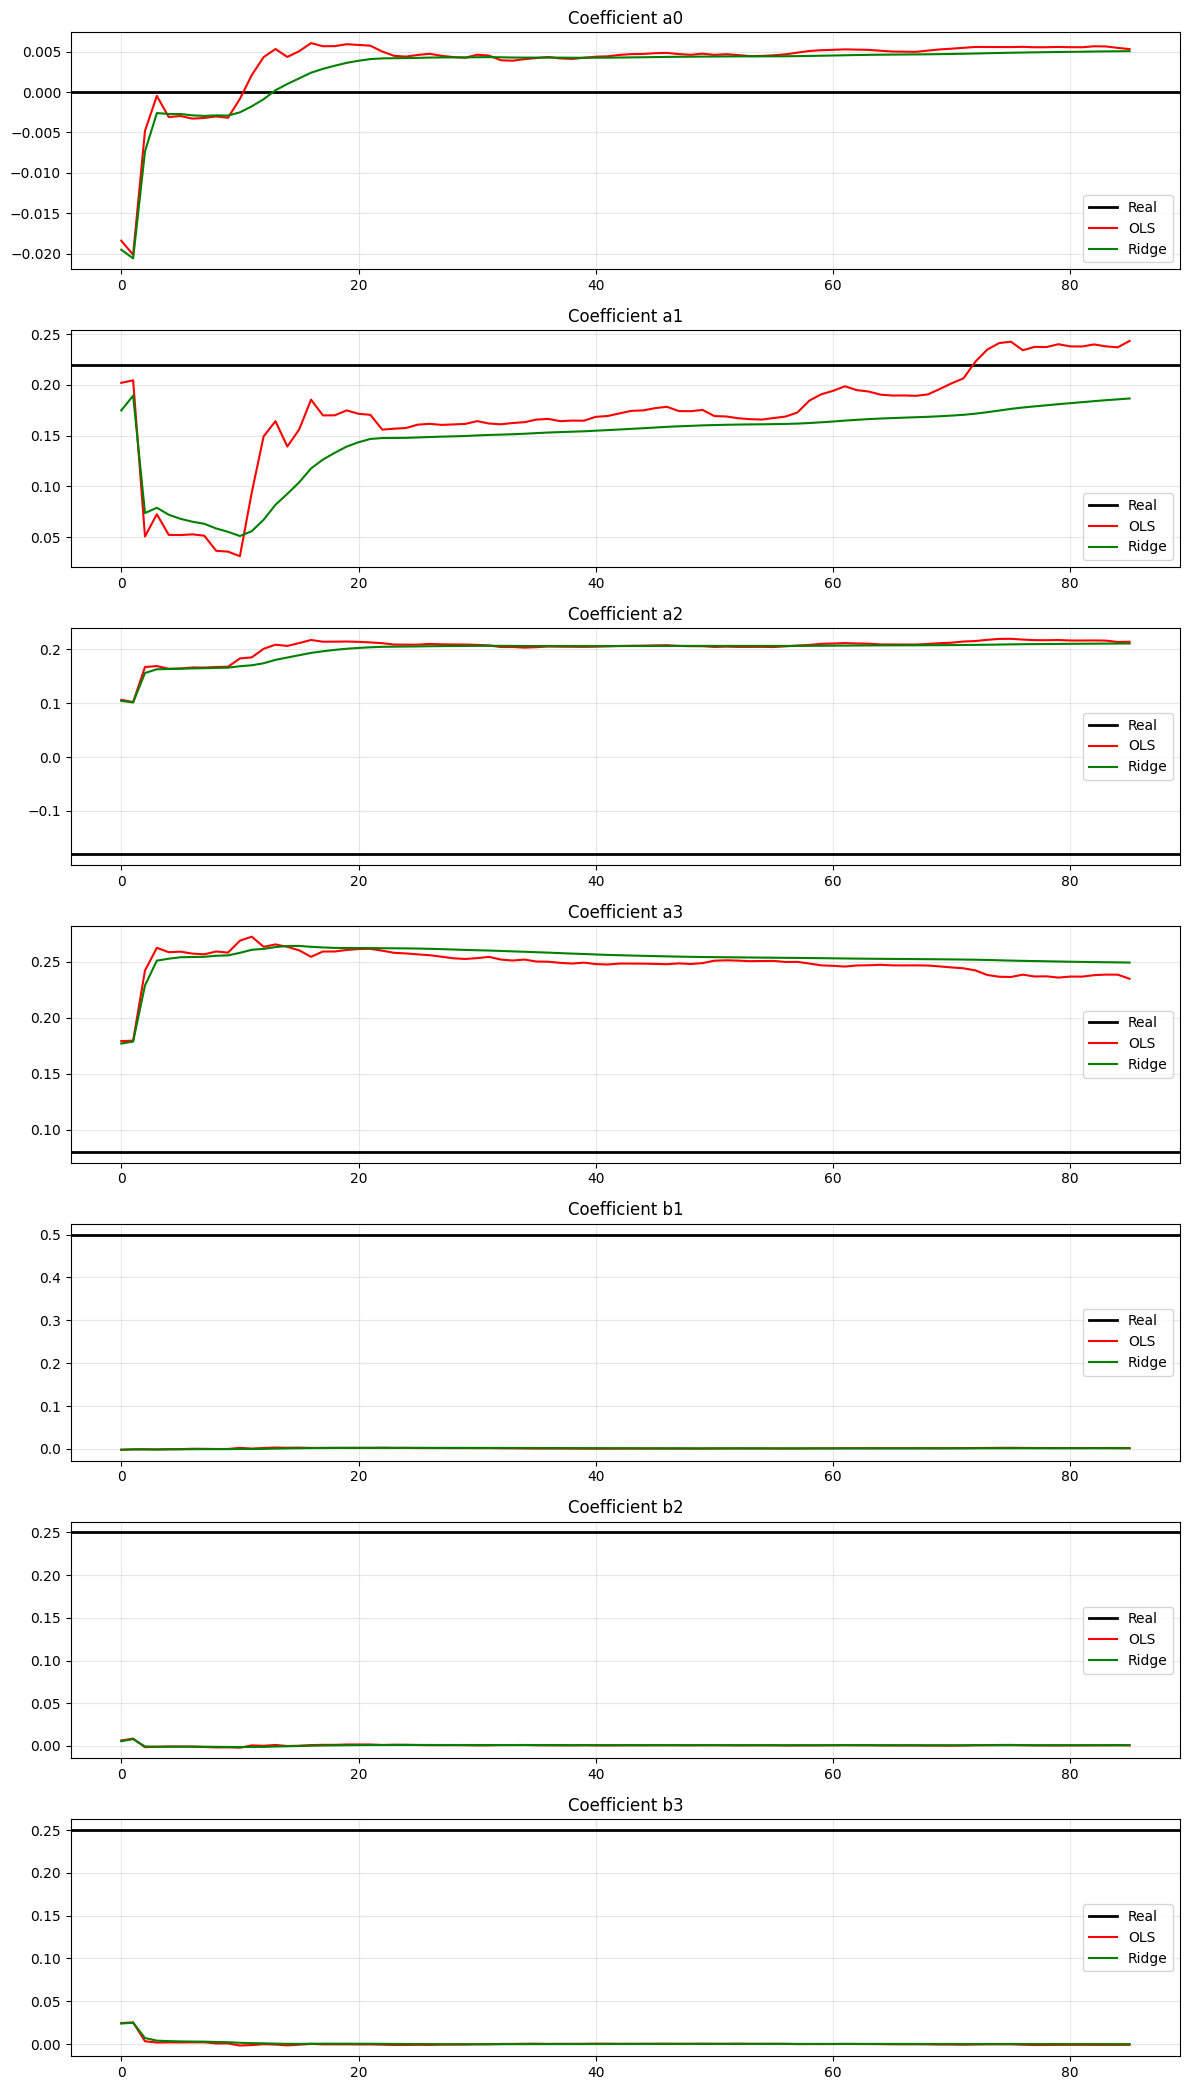

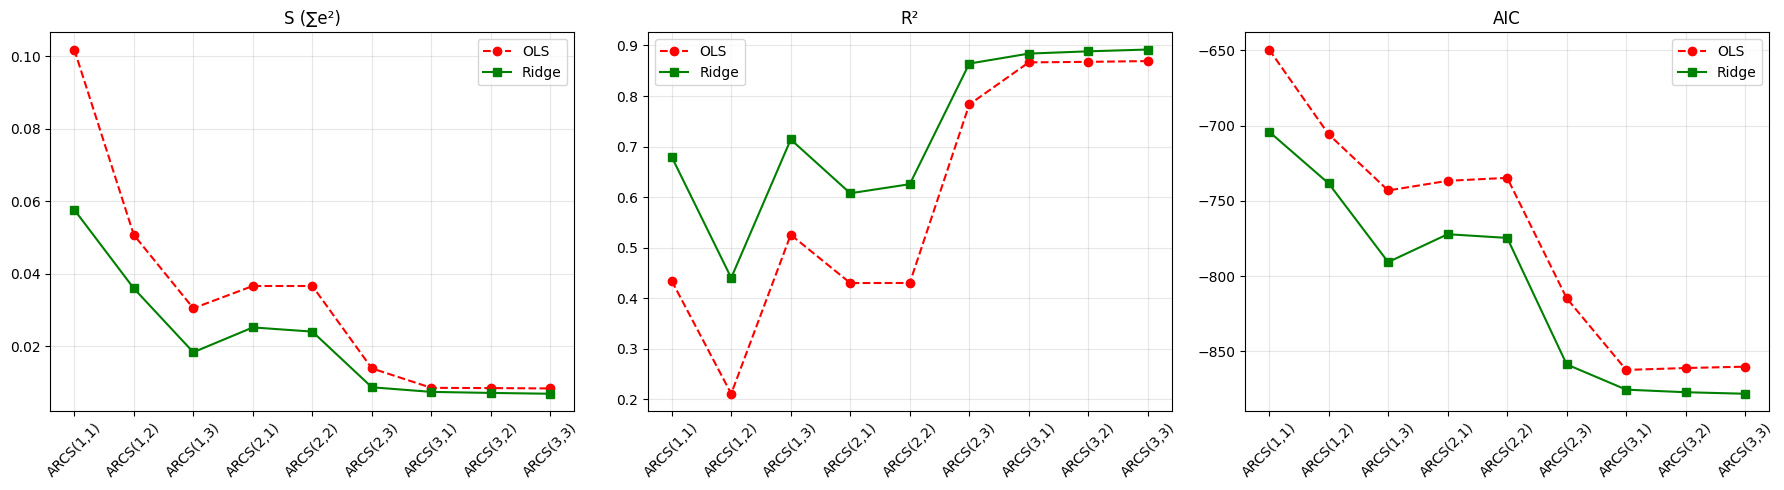

In [44]:
def main():
    results_dir = "results"
    os.makedirs(results_dir, exist_ok=True)

    y, v = load_data()
    print("Data loaded for your model.")
    
    df = build_wide_table(y, v)
    
    # Format all float columns to 6 decimal places
    float_cols = df.select_dtypes(include=['float']).columns
    df[float_cols] = df[float_cols].map(lambda x: f"{x:.6f}")
    
    print("\nResults of 9 models (1 ≤ p ≤ 3, 1 ≤ q ≤ 3):")
    print(tabulate(df, headers='keys', tablefmt='pretty'))

    csv_path = os.path.join(results_dir, "results_wide.csv")
    df.to_csv(csv_path, index=False)
    print(f"Table saved to {csv_path}")

    # Real coefficients
    real_coeffs = {"a0": a0, "a1": a1, "a2": a2, "a3": a3,
                   "b1": b1, "b2": b2, "b3": b3}
    
    # Recursive estimation
    est_ols = recursive_estimation(y, v, p=3, q=3, method="ols")
    est_ridge = recursive_estimation(y, v, p=3, q=3, method="ridge")
    
    plot_coefficients_evolution(real_coeffs, est_ols, est_ridge)

    labels, results_ols, results_ridge = build_table(y, v)
    plot_model_quality(labels, results_ols, results_ridge)

if __name__ == "__main__":
    main()